# 4章

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

# 1変数関数の勾配

In [2]:
def numerical_diff(f,x):
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2 * h)

In [3]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

求めた勾配から接線の関数を求める関数

In [4]:
def tangent_line(f,x):
    d = numerical_diff(f,x)
    print(d)
    y = f(x) - d*x
    return lambda t:d*t + y

0.1999999999990898
0.2999999999986347


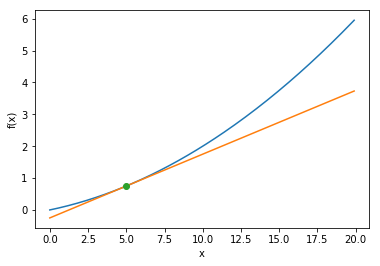

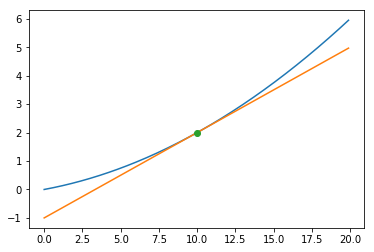

In [5]:
x = np.arange(0.0,20.0,0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")

tf1 = tangent_line(function_1,5)
y1 = tf1(x)

tf2 = tangent_line(function_1,10)
y2 = tf2(x)

plt.plot(x,y)
plt.plot(x,y1)
plt.plot(5,function_1(5),"o")
plt.show()

plt.plot(x,y)
plt.plot(x,y2)
plt.plot(10,function_1(10),"o")
plt.show()

# 2変数関数の勾配

### 追加ライブラリのインポート

In [6]:
from mpl_toolkits.mplot3d import Axes3D

### 2変数関数対応の勾配を算出する関数

- _numerical_gradient_no_batch
- numerical_gradient

In [7]:
def _numerical_gradient_no_batch(f,x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)
        
        x[idx] = tmp_val - h
        fxh2 = f(x)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val
        
    return grad

In [8]:
def numerical_gradient(f,X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f,X)
    else:
        grad = np.zeros_like(X)
        
        for idx,x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f,x)
            
        return grad

In [9]:
def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2,axis=1)

In [10]:
def tangent_line(f,x):
    d = numerical_gradient(f,x)
    print(d)
    y = f(x) - d * x
    return lambda t: d*t + y

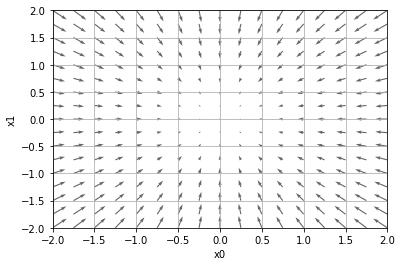

In [14]:
x0 = np.arange(-2,2.5,0.25)
x1 = np.arange(-2,2.5,0.25)
X,Y = np.meshgrid(x0,x1)
X = X.flatten()
Y = Y.flatten()

grad = numerical_gradient(function_2,np.array([X,Y]))

plt.figure()
plt.quiver(X,Y,-grad[0],-grad[1],angles="xy",color="#666666")
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.draw()
plt.show()

# 勾配降下法

$W$ - ニューラルネットワークのweight

$L$ - 損失関数(loss function)

$\eta$ - 学習率

$$
W_n \leftarrow W_n - \eta \frac{\partial L}{\partial W_n}
$$

In [15]:
def gradient_descent(f,init_x,lr=0.01,step_num=100):
    x = init_x
    x_history = []
    
    for i in range(step_num):
        x_history.append(x.copy())
        grad = numerical_gradient(f,x)
        x -= lr * grad
        
    return x,np.array(x_history)

In [16]:
def function_2(x):
    return x[0]**2 + x[1]**2

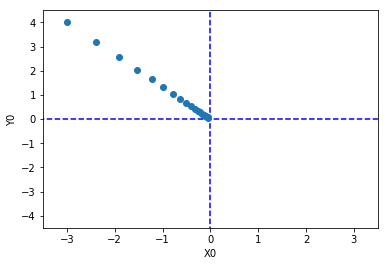

In [17]:
init_x = np.array([-3.0,4.0])

lr = 0.1
step_num = 20
x,x_history = gradient_descent(function_2,init_x,lr=lr,step_num=step_num)

plt.plot([-5,5],[0,0],'--b')
plt.plot([0,0],[-5,5],'--b')
plt.plot(x_history[:,0],x_history[:,1],'o')

plt.xlim(-3.5,3.5)
plt.ylim(-4.5,4.5)
plt.xlabel("X0")
plt.ylabel("Y0")
plt.show()

# ニューラルネットワークの学習をしてみる

ここではランダムな値でweightを生成し、それと教師データとの誤差値を求める。

これにより損失関数の勾配$\frac{\partial L}{\partial W}$を出力する。

### 追加ライブラリのインポート

In [20]:
import os,sys
sys.path.append(os.pardir)
from common.functions import softmax,cross_entropy_error
from common.gradient import numerical_gradient

### 簡易ネットワークの実装

#### simpleNet

- \__init__ : ネットワークのweightをランダムに生成

- predict : ネットワークの予測値を出力

- loss : 入力データと教師データを引数とし、入力データによる予測値と教師データとの誤差を交差エントロピー誤差関数で計算し出力

#### 予測値の計算

$$
predict(x) = xW
$$

$$
predict(x)=\left(
    \begin{array}{cc}
        x_0 & x_1
    \end{array}
\right)
\left(
    \begin{array}{ccc}
        w_{11} & w_{12} & w_{13} \\
        w_{21} & w_{22} & w_{23}
    \end{array}
\right)
=\left(
    \begin{array}{ccc}
        x_0 w_{11} + x_1 w_{21} & x_0 w_{12} + x_1 w_{22} & x_0 w_{13} + x_1 w_{23}
    \end{array}
\right)
$$

In [26]:
class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3)
        
    def predict(self,x):
        return np.dot(x,self.W)
    
    def loss(self,x,t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y,t)
        
        return loss

### 入力データと教師データの準備

#### データ

- x : 入力データ

- t : 教師データ(one-hot表現となっている)

In [22]:
x = np.array([0.6,0.9])
t = np.array([0,0,1])

In [41]:
net = simpleNet()

f = lambda w:net.loss(x,t)
dW = numerical_gradient(f,net.W)
print(dW)

[[ 0.12327996  0.39665969 -0.51993965]
 [ 0.18491994  0.59498954 -0.77990948]]


# 2層ニューラルネットワーク

In [42]:
from common.functions import *

以下は入力層サイズ(2) 隠れ層サイズ(3) 出力層サイズ(4)として初期化したニューラルネットワークの計算の変遷である。

$$
a1 = 
\left(
    \begin{array}{cc}
        x_1 & x_2
    \end{array}
\right)
\left(
    \begin{array}{ccc}
        w1_{11} & w1_{21} & w1_{31} \\
        w1_{12} & w1_{22} & w1_{32} \\
    \end{array}
\right)
+
\left(
    \begin{array}{ccc}
        b1_1 &
        b1_2 &
        b1_3
    \end{array}
\right)
$$

$$
z1 = sigmoid(a1)
$$

$$
a2 = 
z1
\left(
    \begin{array}{cccc}
        w2_{11} & w2_{21} & w2_{31} & w2_{41}\\
        w2_{12} & w2_{22} & w2_{32} & w2_{42}\\
        w2_{13} & w2_{23} & w2_{33} & w2_{43}
    \end{array}
\right)
+
\left(
    \begin{array}{ccc}
        b2_1 &
        b2_2 &
        b2_3 &
        b2_4
    \end{array}
\right)
$$

$$
y = softmax(a2)
$$

In [44]:
class TwoLayerNet:
    def __init__(self,input_size,hidden_size,output_size,weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size,hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size,output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self,x):
        W1,W2 = self.params['W1'],self.params['W2']
        b1,b2 = self.params['b1'],self.params['b2']
        
        a1 = np.dot(x,W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1,W2) + b2
        y = softmax(a2)
        
        return y
    
    def loss(self,x,t):
        y = self.predict(x)
        
        return cross_entropy_error(y,t)
    
    def accuracy(self,x,t):
        y = self.predict(x)
        y = np.argmax(y,axis=1)
        t = np.argmax(t,axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self,x,t):
        loss_W = lambda W:self.loss(x,t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W,self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W,self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W,self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W,self.params['b2'])
        return grads
    
    def gradient(self,x,t):
        W1,W2 = self.params['W1'],self.params['W2']
        b1,b2 = self.params['b1'],self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        a1 = np.dot(x,W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1,W2) + b2
        y = softmax(a2)
        
        dy = (y-t) / batch_num
        grads['W2'] = np.dot(z1.T,dy)
        grads['b2'] = np.sum(dy,axis=0)
        
        da1 = np.dot(dy,W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T,dz1)
        grads['b1'] = np.sum(dz1,axis=0)
        
        return grads

# 実際に学習させてみる

In [45]:
from dataset.mnist import load_mnist

train acc,test_acc | 0.10441666666666667, 0.1028
train acc,test_acc | 0.797, 0.8008
train acc,test_acc | 0.8770333333333333, 0.8814
train acc,test_acc | 0.8975333333333333, 0.9019
train acc,test_acc | 0.9071333333333333, 0.9106
train acc,test_acc | 0.9143333333333333, 0.9149
train acc,test_acc | 0.9188666666666667, 0.9188
train acc,test_acc | 0.9231833333333334, 0.9227
train acc,test_acc | 0.9270166666666667, 0.9269
train acc,test_acc | 0.9299833333333334, 0.9285
train acc,test_acc | 0.93285, 0.9323
train acc,test_acc | 0.93485, 0.9334
train acc,test_acc | 0.93795, 0.9362
train acc,test_acc | 0.9398333333333333, 0.9378
train acc,test_acc | 0.9419166666666666, 0.9403
train acc,test_acc | 0.94305, 0.9401
train acc,test_acc | 0.94505, 0.9436


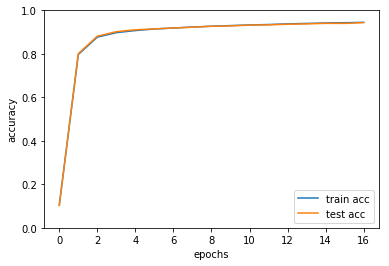

In [46]:
(x_train,t_train),(x_test,t_test) = load_mnist(normalize=True,one_hot_label=True)

network = TwoLayerNet(input_size=784,hidden_size=50,output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size,1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size,batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch,t_batch)
    
    for key in ('W1','b1','W2','b2'):
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(x_batch,t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train,t_train)
        test_acc = network.accuracy(x_test,t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc,test_acc | " + str(train_acc) + ", " + str(test_acc))
        
markers = {'train' : 'o' , 'test' : 's'}
x = np.arange(len(train_acc_list))
plt.plot(x,train_acc_list,label='train acc')
plt.plot(x,test_acc_list,label='test acc')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0,1.0)
plt.legend(loc='lower right')
plt.show()